<a href="https://colab.research.google.com/github/fcoliveira-utfpr/climate_parana/blob/main/analises_clima_parana.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Início - Bibliotecas
---

In [27]:
# -------------------------
# IMPORTS
# -------------------------
!pip install geobr   -q
import numpy as np
import pandas as pd
import geopandas as gpd
import pandas as pd
from geobr import read_municipality
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import math
import matplotlib.colors as colors
import matplotlib.cm as cm
from geobr import read_municipality
from matplotlib.ticker import FuncFormatter

# Abrindo dados
---

In [2]:
url = "https://raw.githubusercontent.com/fcoliveira-utfpr/climate_parana/refs/heads/main/dados_concatenados_zc.csv"
df = pd.read_csv(url, sep = ",")
df

,estado,lat,lon,municipio,valor,variavel,ZC
0,Parana,-23.311363,-50.306176,ABATIA,210.718086,def,7601
1,Parana,-25.884047,-53.640829,BELA VISTA DA CAROBA,87.526841,def,6801
2,Parana,-24.781986,-48.819381,ADRIANOPOLIS,54.045608,def,6801
3,Parana,-26.025501,-49.309155,AGUDOS DO SUL,33.173108,def,6801
4,Parana,-25.284879,-49.322794,ALMIRANTE TAMANDARE,35.327444,def,6801
...,...,...,...,...,...,...,...
2395,Parana,-23.538200,-53.825424,ALTO PARAISO,28.208377,tmmx,7701
2396,Parana,-25.408510,-52.236439,VIRMOND,24.368879,tmmx,6801
2397,Parana,-26.277366,-52.804057,VITORINO,24.684439,tmmx,6901
2398,Parana,-23.853953,-49.783944,WENCESLAU BRAZ,25.967448,tmmx,7601


#Plotando mapa variáveis
---

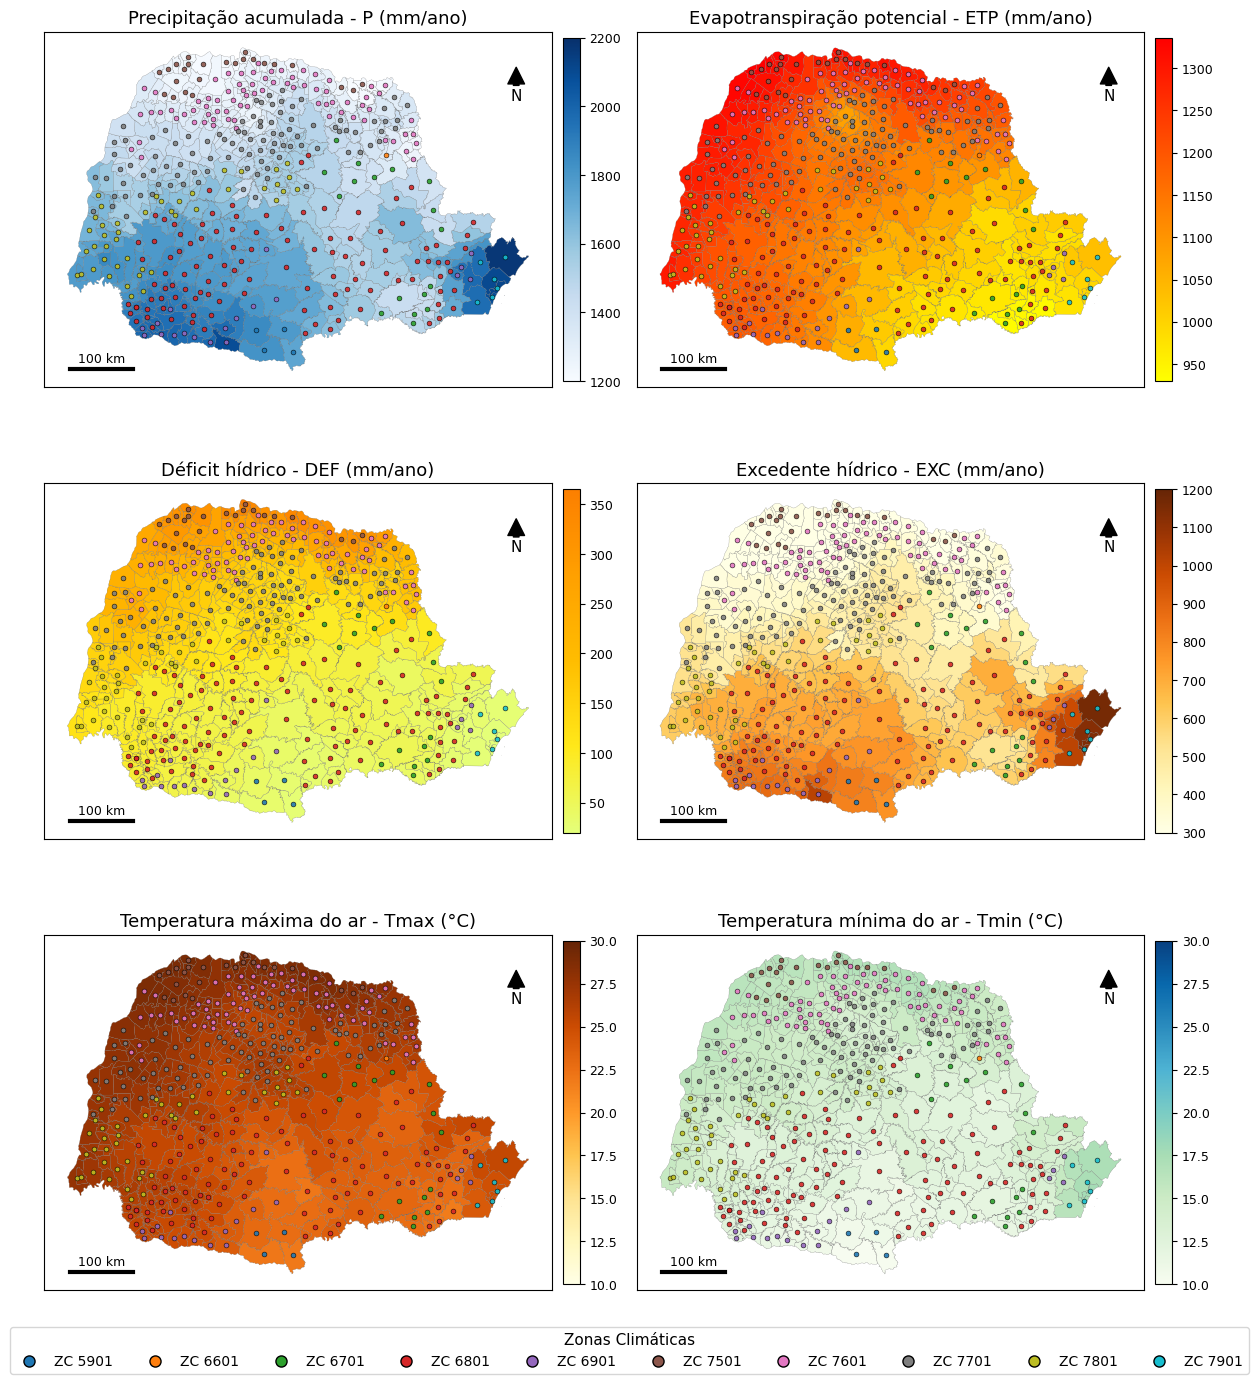

In [16]:
# =========================================================
# MULTIPLOT CLIMÁTICO – PARANÁ
# MAPAS CONTÍNUOS + ZONAS CLIMÁTICAS (LEGENDA ÚNICA)
# =========================================================

import math
import warnings
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from matplotlib.ticker import FuncFormatter
from matplotlib.lines import Line2D
import geopandas as gpd
from geobr import read_municipality

# ---------------------------------------------------------
# SILENCIAR WARNINGS
# ---------------------------------------------------------
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# -------------------------
# FUNÇÕES AUXILIARES
# -------------------------
def fmt_factory(fmt):
    return FuncFormatter(lambda x, pos: fmt % x)

def add_north_arrow(ax, x=0.93, y=0.9, size=0.08):
    ax.annotate(
        'N',
        xy=(x, y),
        xytext=(x, y - size),
        arrowprops=dict(facecolor='black', width=4, headwidth=12),
        ha='center',
        va='center',
        fontsize=11,
        xycoords=ax.transAxes
    )

def add_scalebar(ax, length_km=100, loc=(0.05, 0.05), linewidth=3):
    x0, y0 = loc
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    length_deg = length_km / 111.0  # aproximação

    x_start = xlim[0] + x0 * (xlim[1] - xlim[0])
    y_start = ylim[0] + y0 * (ylim[1] - ylim[0])

    ax.plot(
        [x_start, x_start + length_deg],
        [y_start, y_start],
        color='black',
        linewidth=linewidth,
        zorder=20
    )

    ax.text(
        x_start + length_deg / 2,
        y_start + 0.01 * (ylim[1] - ylim[0]),
        f"{length_km} km",
        ha='center',
        va='bottom',
        fontsize=9
    )

# -------------------------
# ESPECIFICAÇÕES DAS VARIÁVEIS
# -------------------------
VAR_SPECS = {
    'pr':   dict(title="Precipitação acumulada - P",        unit="mm/ano", cmap='Blues',    vmin=1200, vmax=2200, fmt="%.0f"),
    'pet':  dict(title="Evapotranspiração potencial - ETP", unit="mm/ano", cmap='autumn_r', vmin=930,  vmax=1336, fmt="%.0f"),
    'def':  dict(title="Déficit hídrico - DEF",              unit="mm/ano", cmap='Wistia',   vmin=20,   vmax=365,  fmt="%.0f"),
    'ro':   dict(title="Excedente hídrico - EXC",            unit="mm/ano", cmap='YlOrBr',   vmin=300,  vmax=1200, fmt="%.0f"),
    'tmmx': dict(title="Temperatura máxima do ar - Tmax",    unit="°C",     cmap='YlOrBr',   vmin=10,   vmax=30,   fmt="%.1f"),
    'tmmn': dict(title="Temperatura mínima do ar - Tmin",    unit="°C",     cmap='GnBu',     vmin=10,   vmax=30,   fmt="%.1f"),
}

vars_plot = list(VAR_SPECS.keys())

# -------------------------
# CORES DAS ZONAS CLIMÁTICAS (EXPLÍCITAS)
# >>> EDITE AQUI SE QUISER <<<
# -------------------------
ZC_COLORS = [
    'tab:blue',
    'tab:orange',
    'tab:green',
    'tab:red',
    'tab:purple',
    'tab:brown',
    'tab:pink',
    'tab:gray',
    'tab:olive',
    'tab:cyan'
]

# -------------------------
# DEFINIR ZONAS CLIMÁTICAS (FONTE CORRETA: DF)
# -------------------------
zonas = sorted(df['ZC'].dropna().unique(), key=lambda x: str(x))

if len(zonas) > len(ZC_COLORS):
    raise ValueError("Número de ZCs maior que a lista de cores.")

zona_color = {z: ZC_COLORS[i] for i, z in enumerate(zonas)}

# -------------------------
# MUNICÍPIOS DO PARANÁ
# -------------------------
mun_pr = read_municipality(code_muni="PR", year=2020)

mun_pr['municipio'] = (
    mun_pr['name_muni']
    .str.upper()
    .str.normalize('NFKD')
    .str.encode('ascii', errors='ignore')
    .str.decode('utf-8')
)

# -------------------------
# LAYOUT DA FIGURA
# -------------------------
n_vars = len(vars_plot)
ncols = 2
nrows = math.ceil(n_vars / ncols)

fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(12, 5 * nrows)
)

axes = axes.flatten()

# -------------------------
# LOOP DE MAPAS
# -------------------------
for i, variavel in enumerate(vars_plot):

    ax = axes[i]
    spec = VAR_SPECS[variavel]

    df_variavel = df[df['variavel'] == variavel].copy()

    df_variavel['municipio'] = (
        df_variavel['municipio']
        .str.upper()
        .str.normalize('NFKD')
        .str.encode('ascii', errors='ignore')
        .str.decode('utf-8')
    )

    gdf_pr = mun_pr.merge(df_variavel, on='municipio', how='left')

    # -------------------------
    # MAPA CONTÍNUO
    # -------------------------
    gdf_pr.plot(
        column='valor',
        cmap=spec['cmap'],
        vmin=spec['vmin'],
        vmax=spec['vmax'],
        linewidth=0.15,
        edgecolor='0.4',
        ax=ax
    )

    # -------------------------
    # COLORBAR
    # -------------------------
    norm = colors.Normalize(vmin=spec['vmin'], vmax=spec['vmax'])
    sm = cm.ScalarMappable(norm=norm, cmap=plt.get_cmap(spec['cmap']))
    sm.set_array([])

    cbar = fig.colorbar(
        sm,
        ax=ax,
        fraction=0.046,
        pad=0.02,
        shrink=0.72,
        format=fmt_factory(spec['fmt'])
    )
    cbar.ax.tick_params(labelsize=9)

    # -------------------------
    # CENTROIDES (CRS PROJETADO)
    # -------------------------
    gdf_pr = gdf_pr.to_crs(epsg=5880)
    gdf_pr['centroid'] = gdf_pr.geometry.centroid
    gdf_pr = gdf_pr.to_crs(epsg=4674)

    # -------------------------
    # PONTOS DAS ZONAS CLIMÁTICAS
    # -------------------------
    for z in zonas:
        sub = gdf_pr[gdf_pr['ZC'] == z]
        if sub.empty:
            continue

        ax.scatter(
            sub.centroid.x,
            sub.centroid.y,
            s=12,
            color=zona_color[z],
            edgecolor='black',
            linewidth=0.4,
            alpha=0.9,
            zorder=10
        )

    # -------------------------
    # ELEMENTOS CARTOGRÁFICOS
    # -------------------------
    add_scalebar(ax, length_km=100)
    add_north_arrow(ax)

    ax.set_title(f"{spec['title']} ({spec['unit']})", fontsize=13)
    ax.set_xticks([])
    ax.set_yticks([])

# -------------------------
# REMOVER SUBPLOTS VAZIOS
# -------------------------
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# -------------------------
# LEGENDA ÚNICA – HORIZONTAL
# -------------------------
legend_elements = [
    Line2D(
        [0], [0],
        marker='o',
        color='none',
        label=f'ZC {z}',
        markerfacecolor=zona_color[z],
        markeredgecolor='black',
        markersize=8
    )
    for z in zonas
]

fig.legend(
    handles=legend_elements,
    loc='lower center',
    ncol=len(zonas),
    frameon=True,
    title='Zonas Climáticas',
    title_fontsize=11,
    fontsize=10,
    bbox_to_anchor=(0.5, 0.05)
)

plt.tight_layout(rect=[0, 0.06, 1, 1])
plt.show()


#BoxPlot por zona

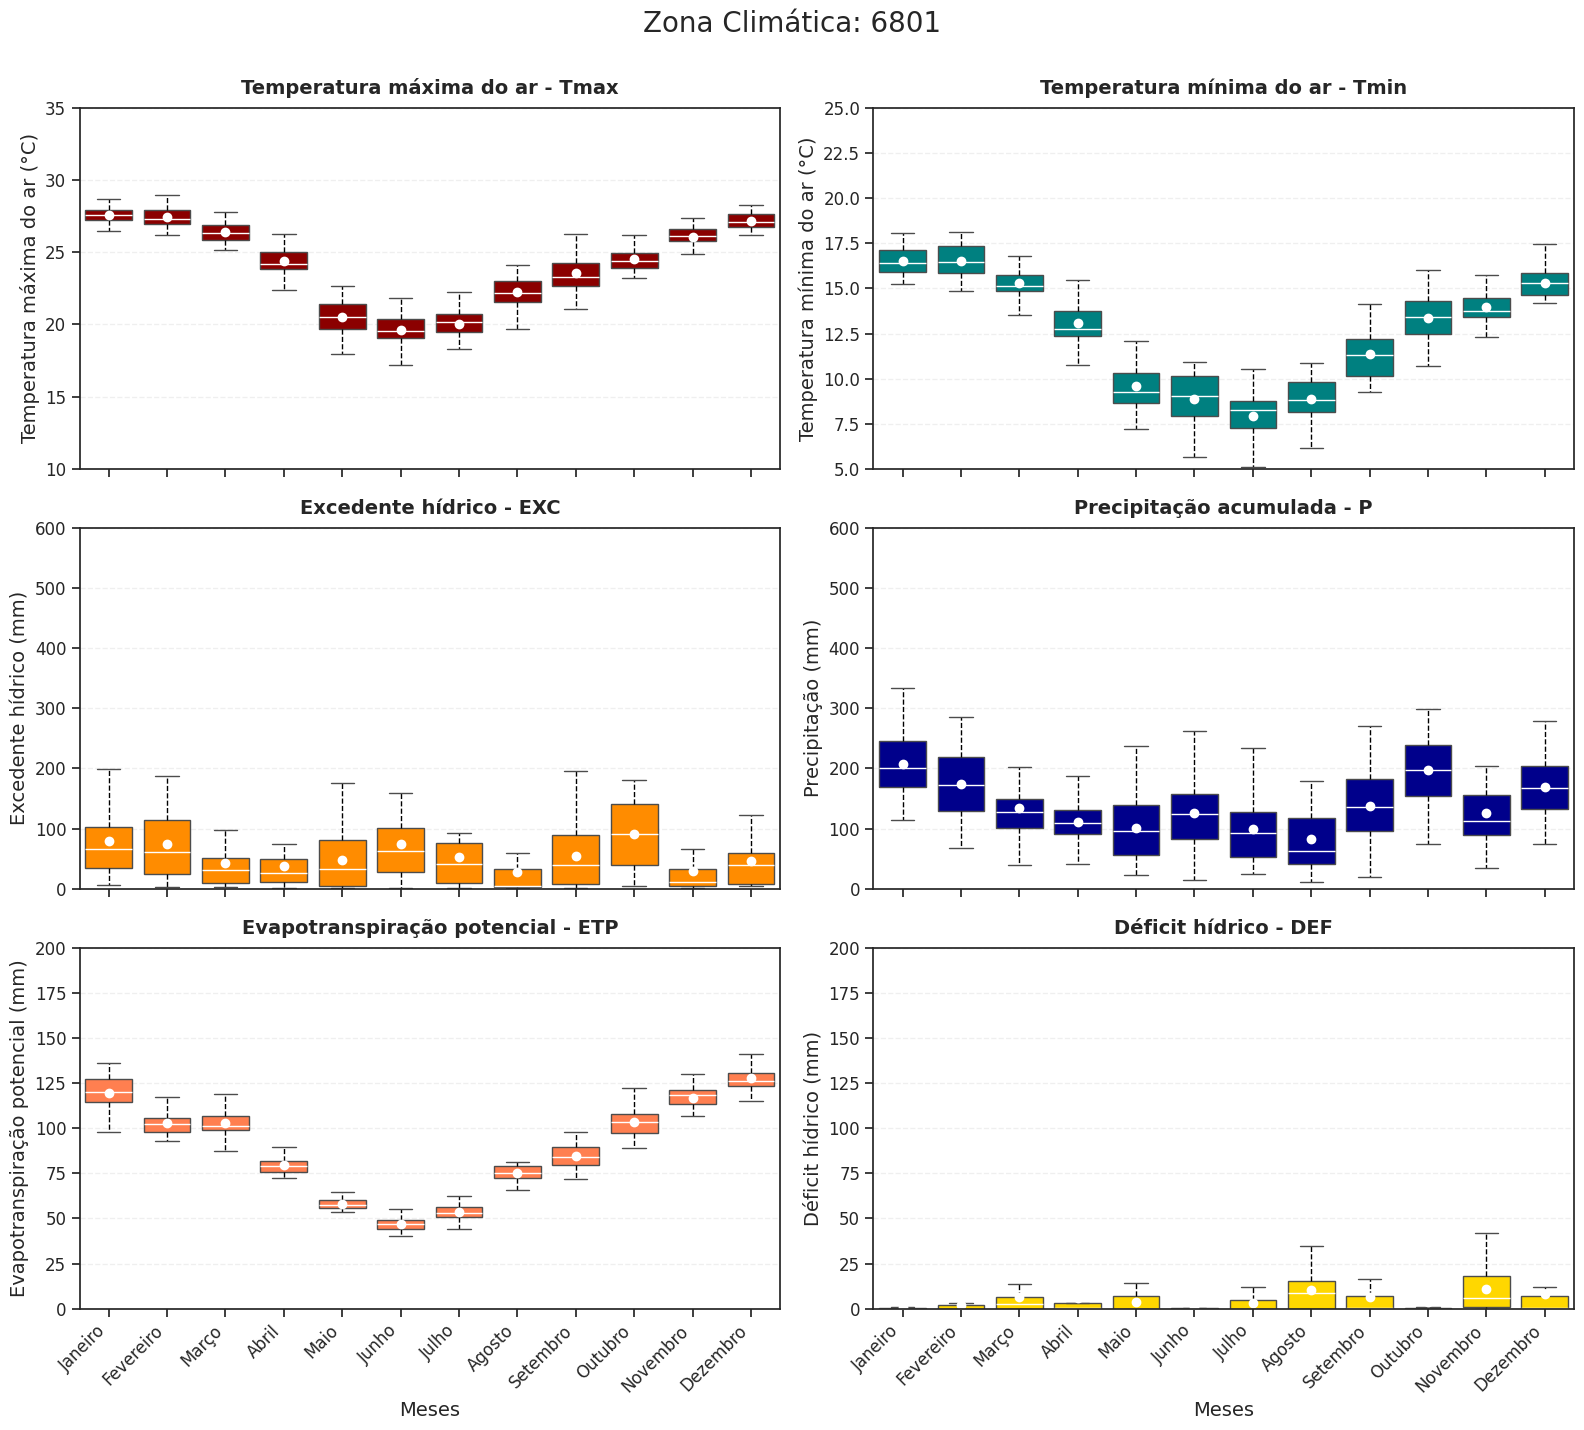

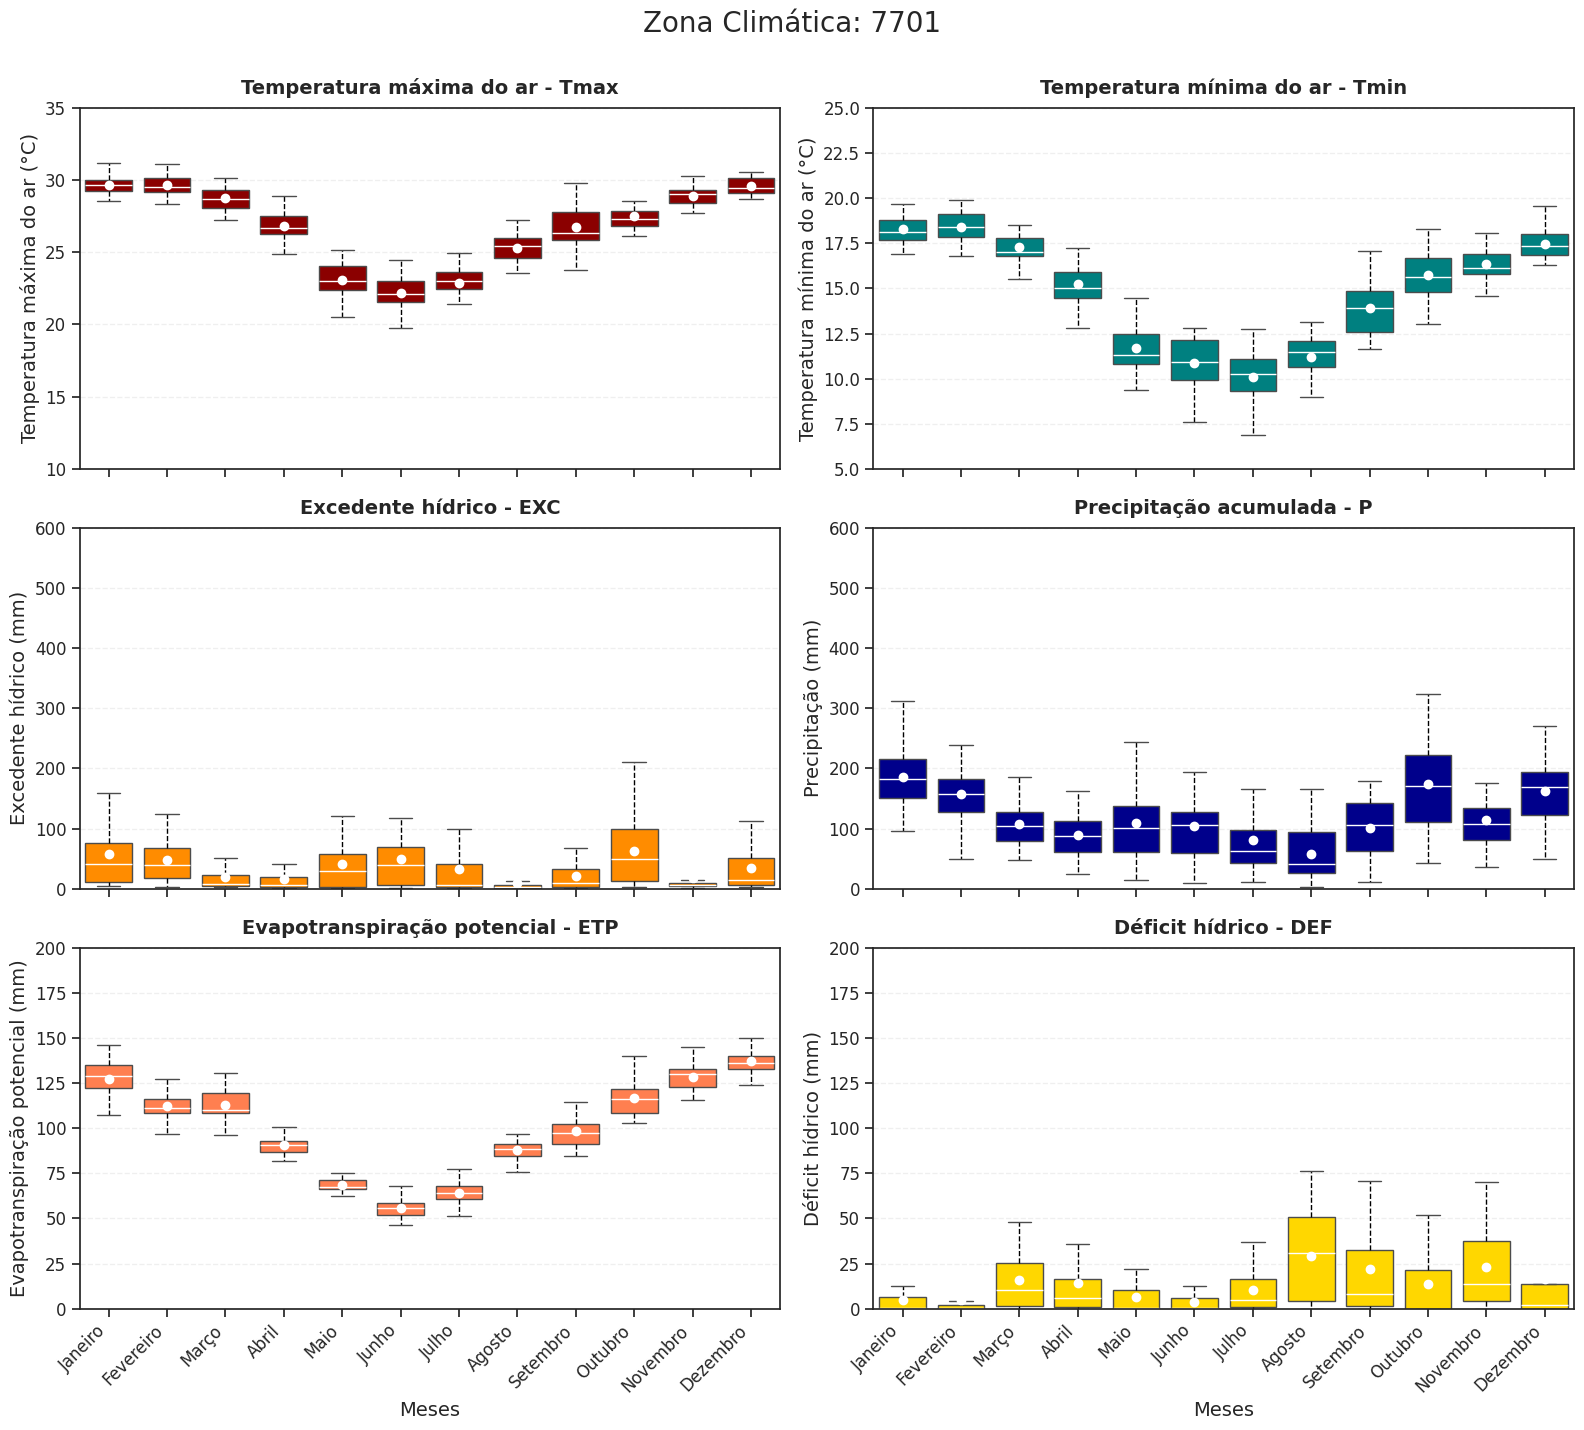

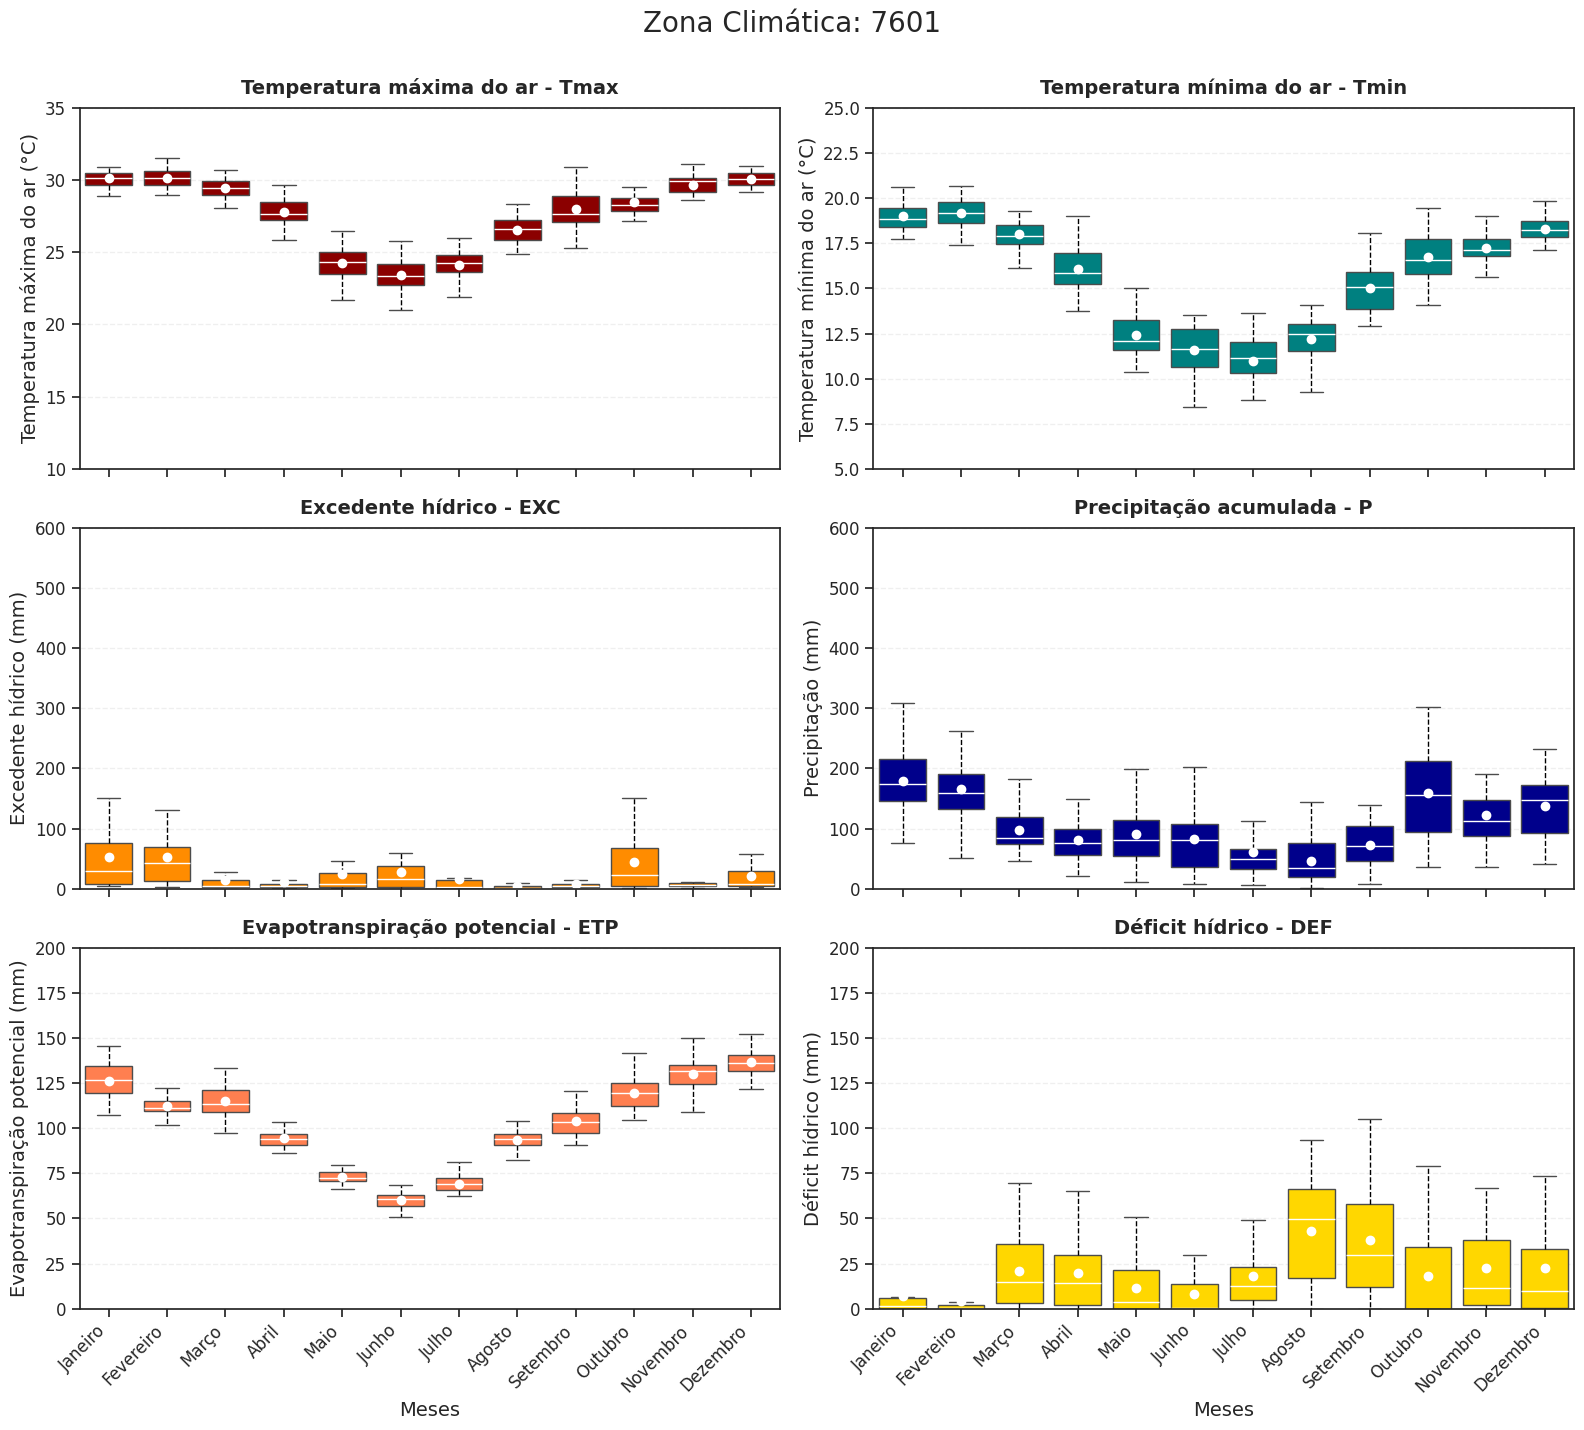

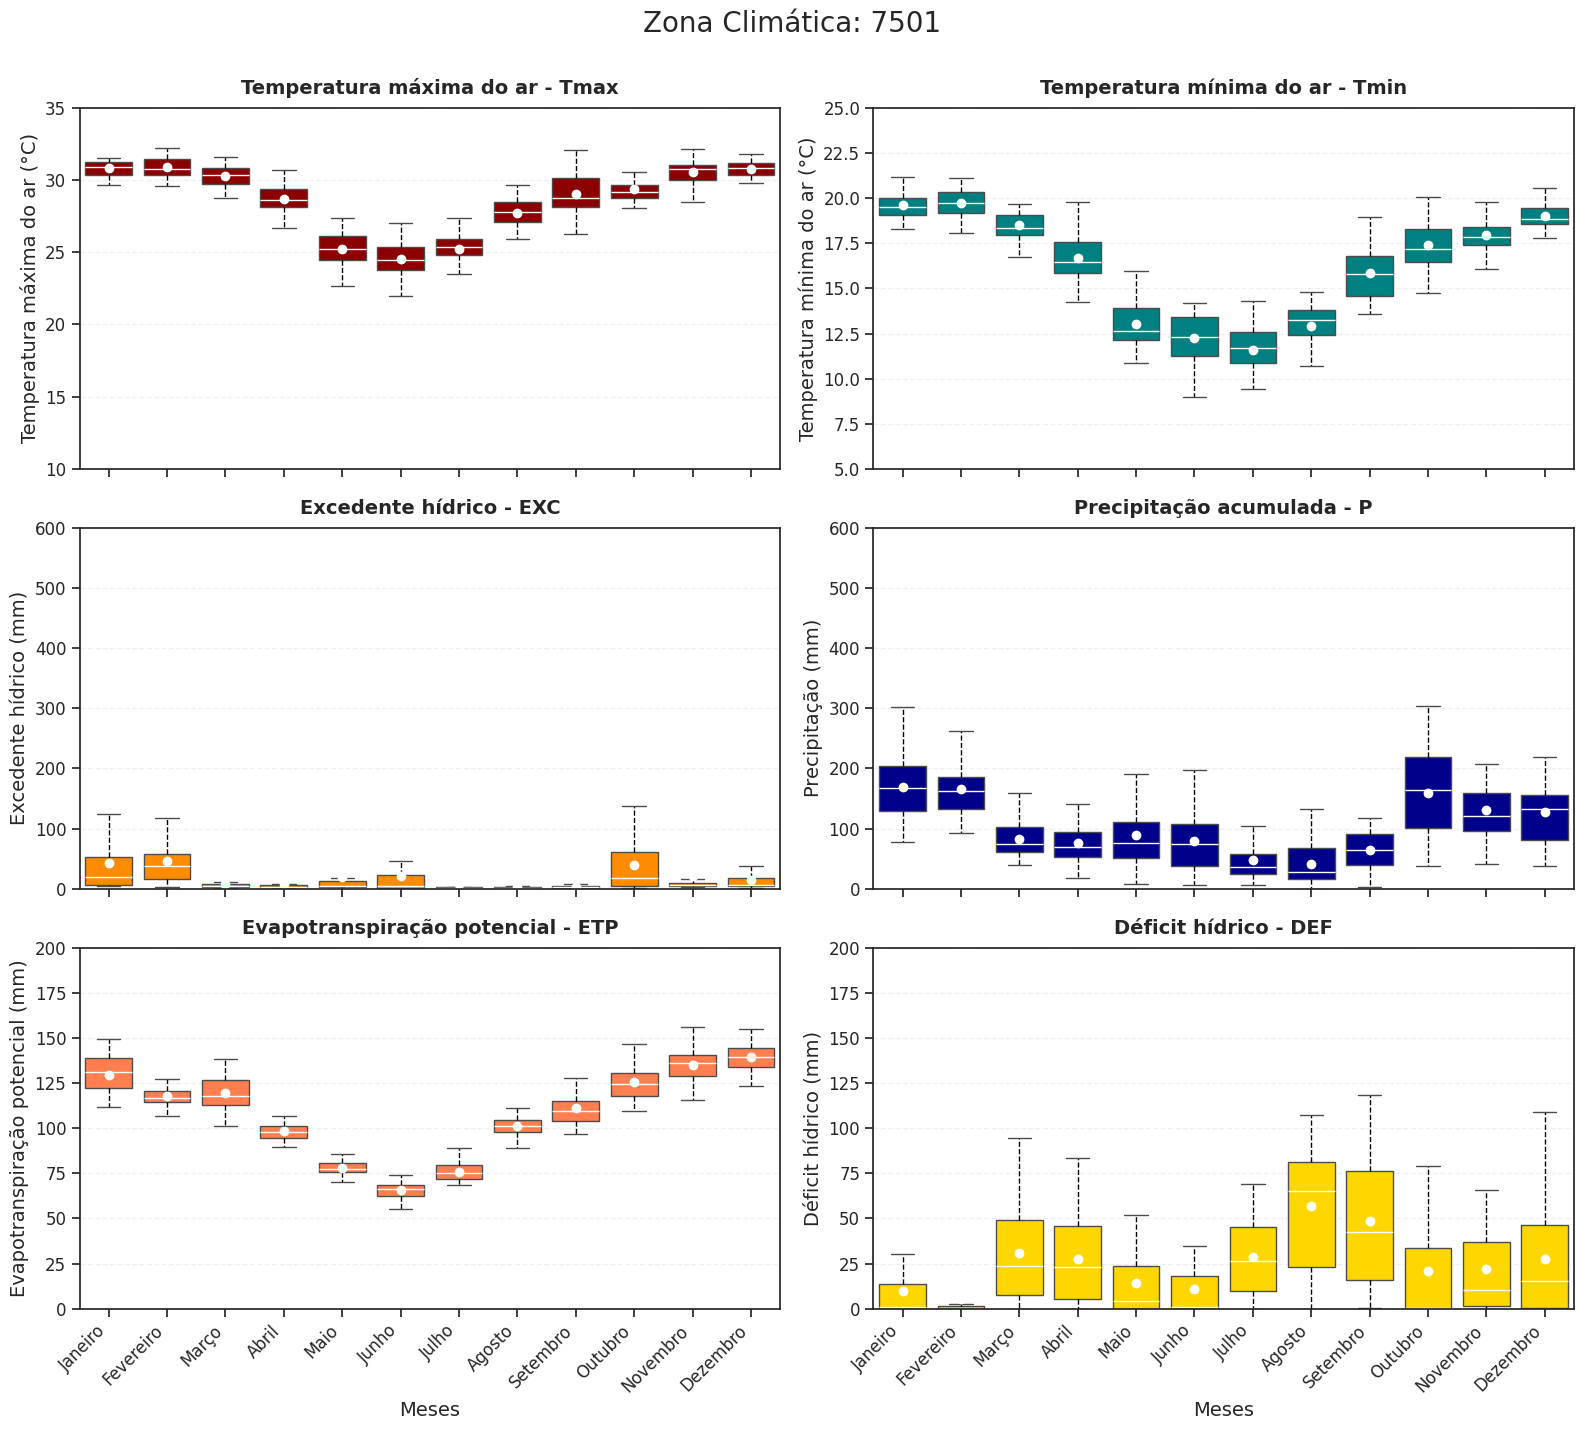

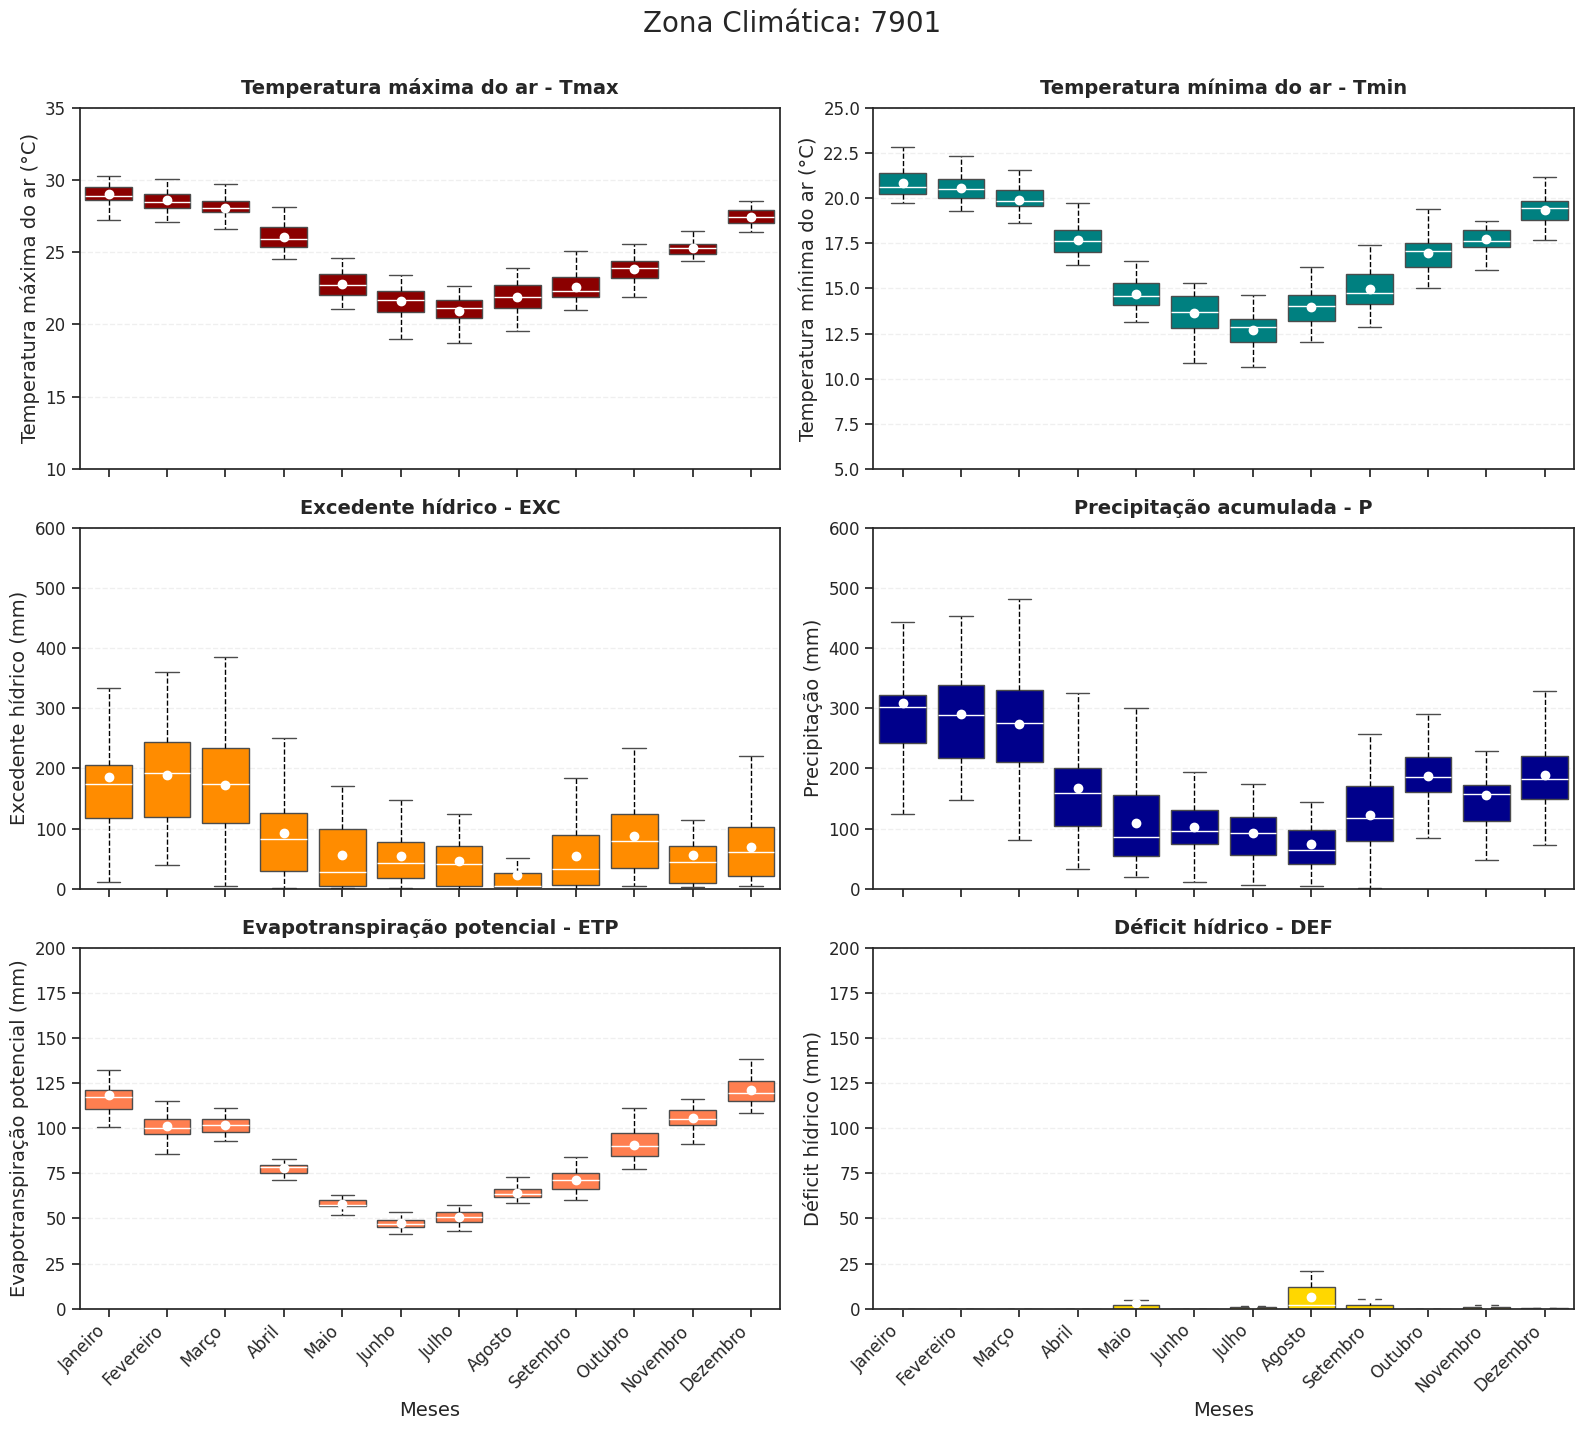

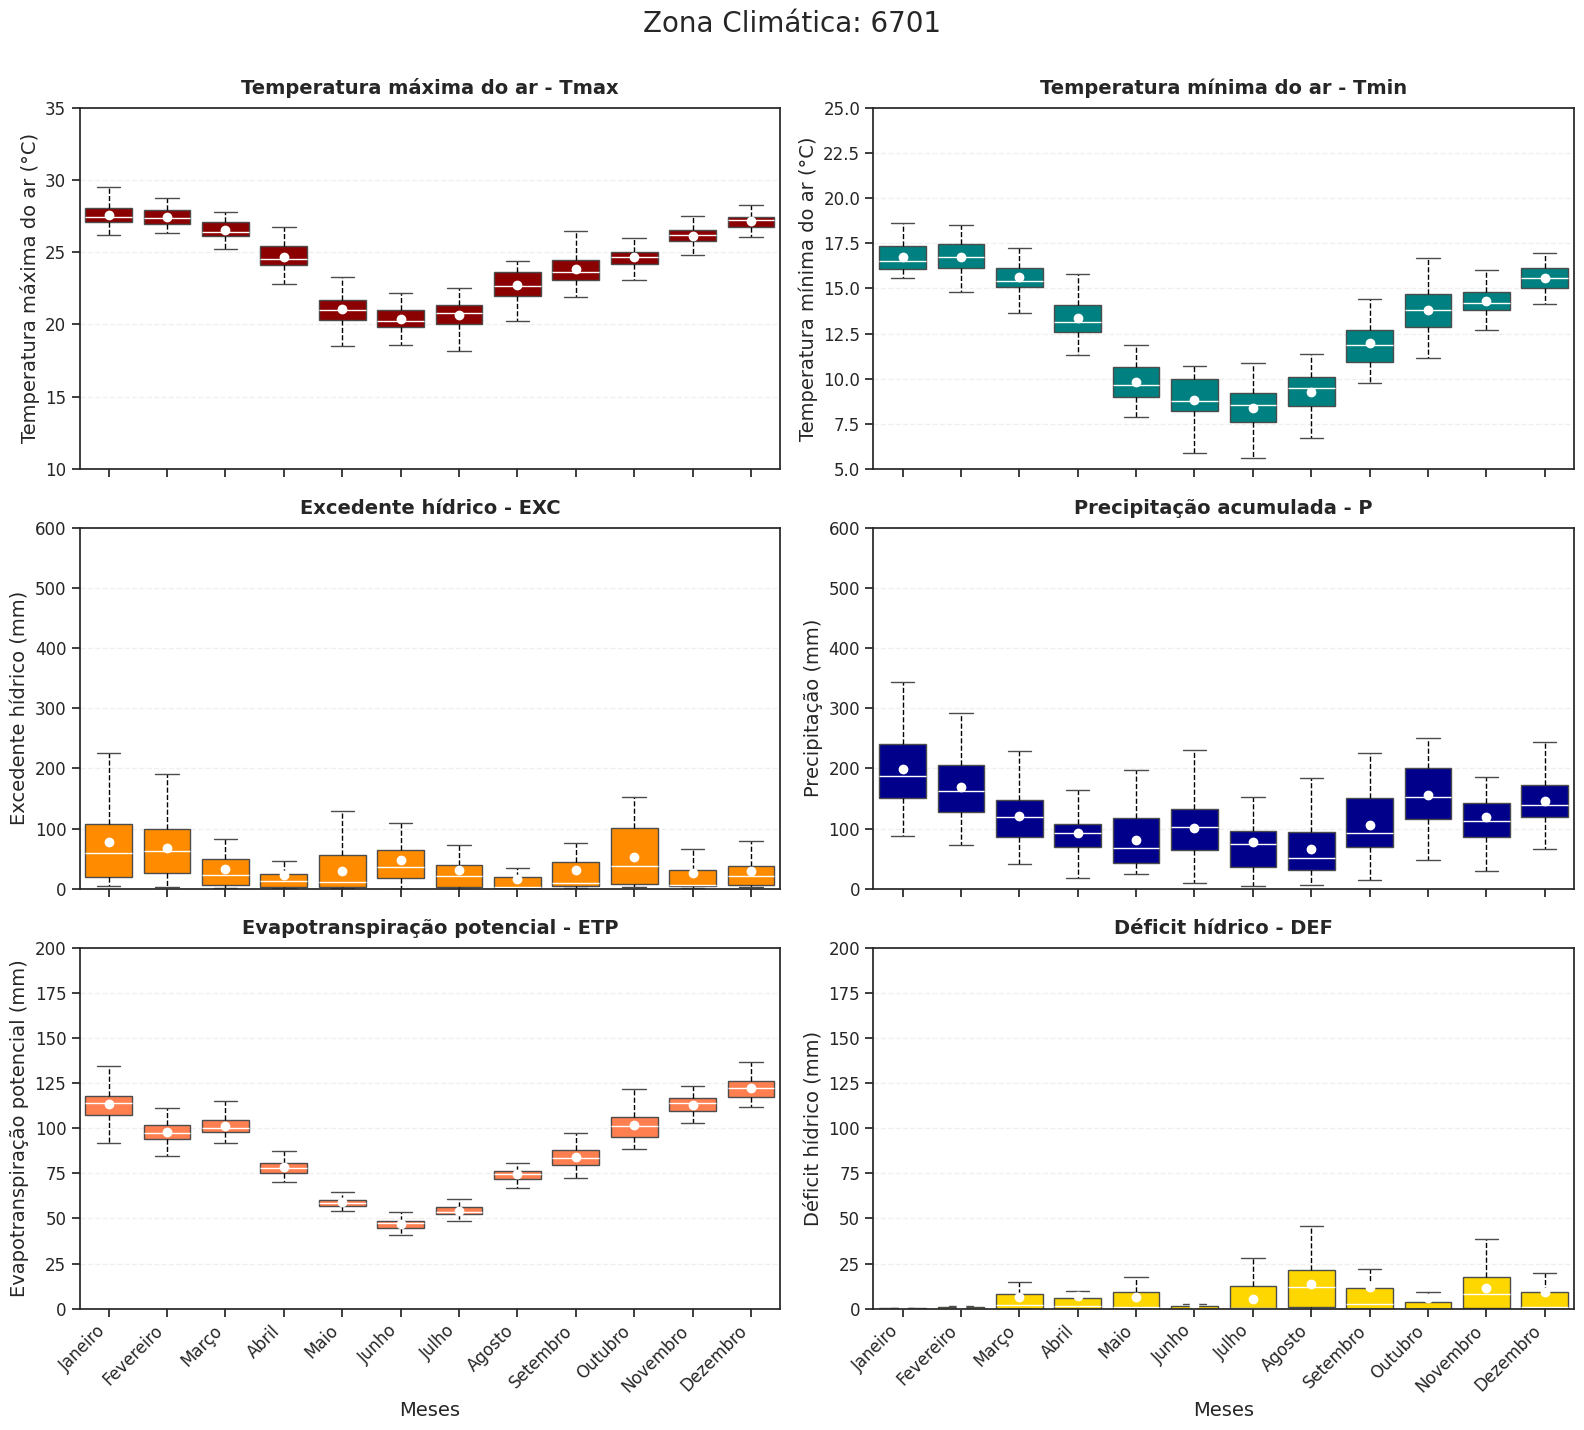

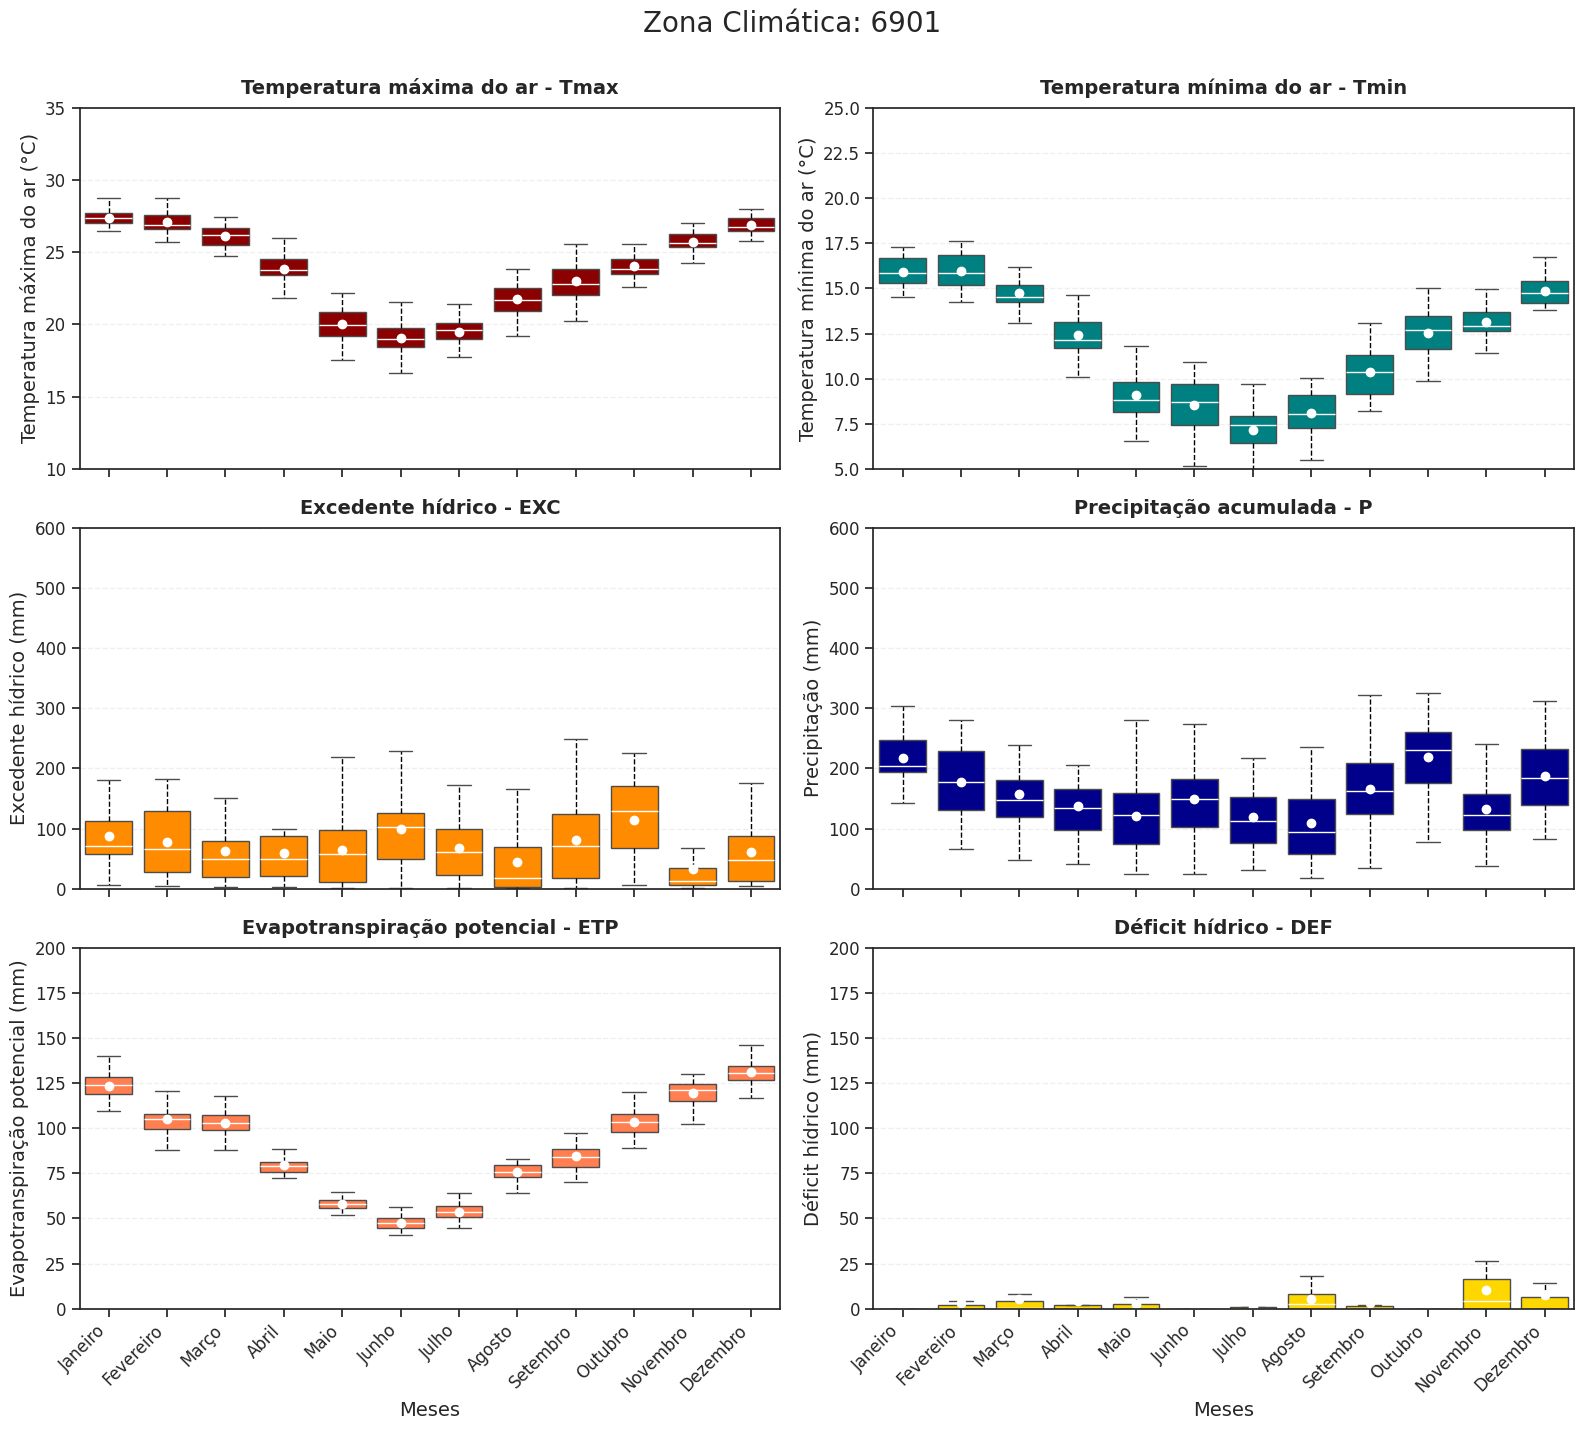

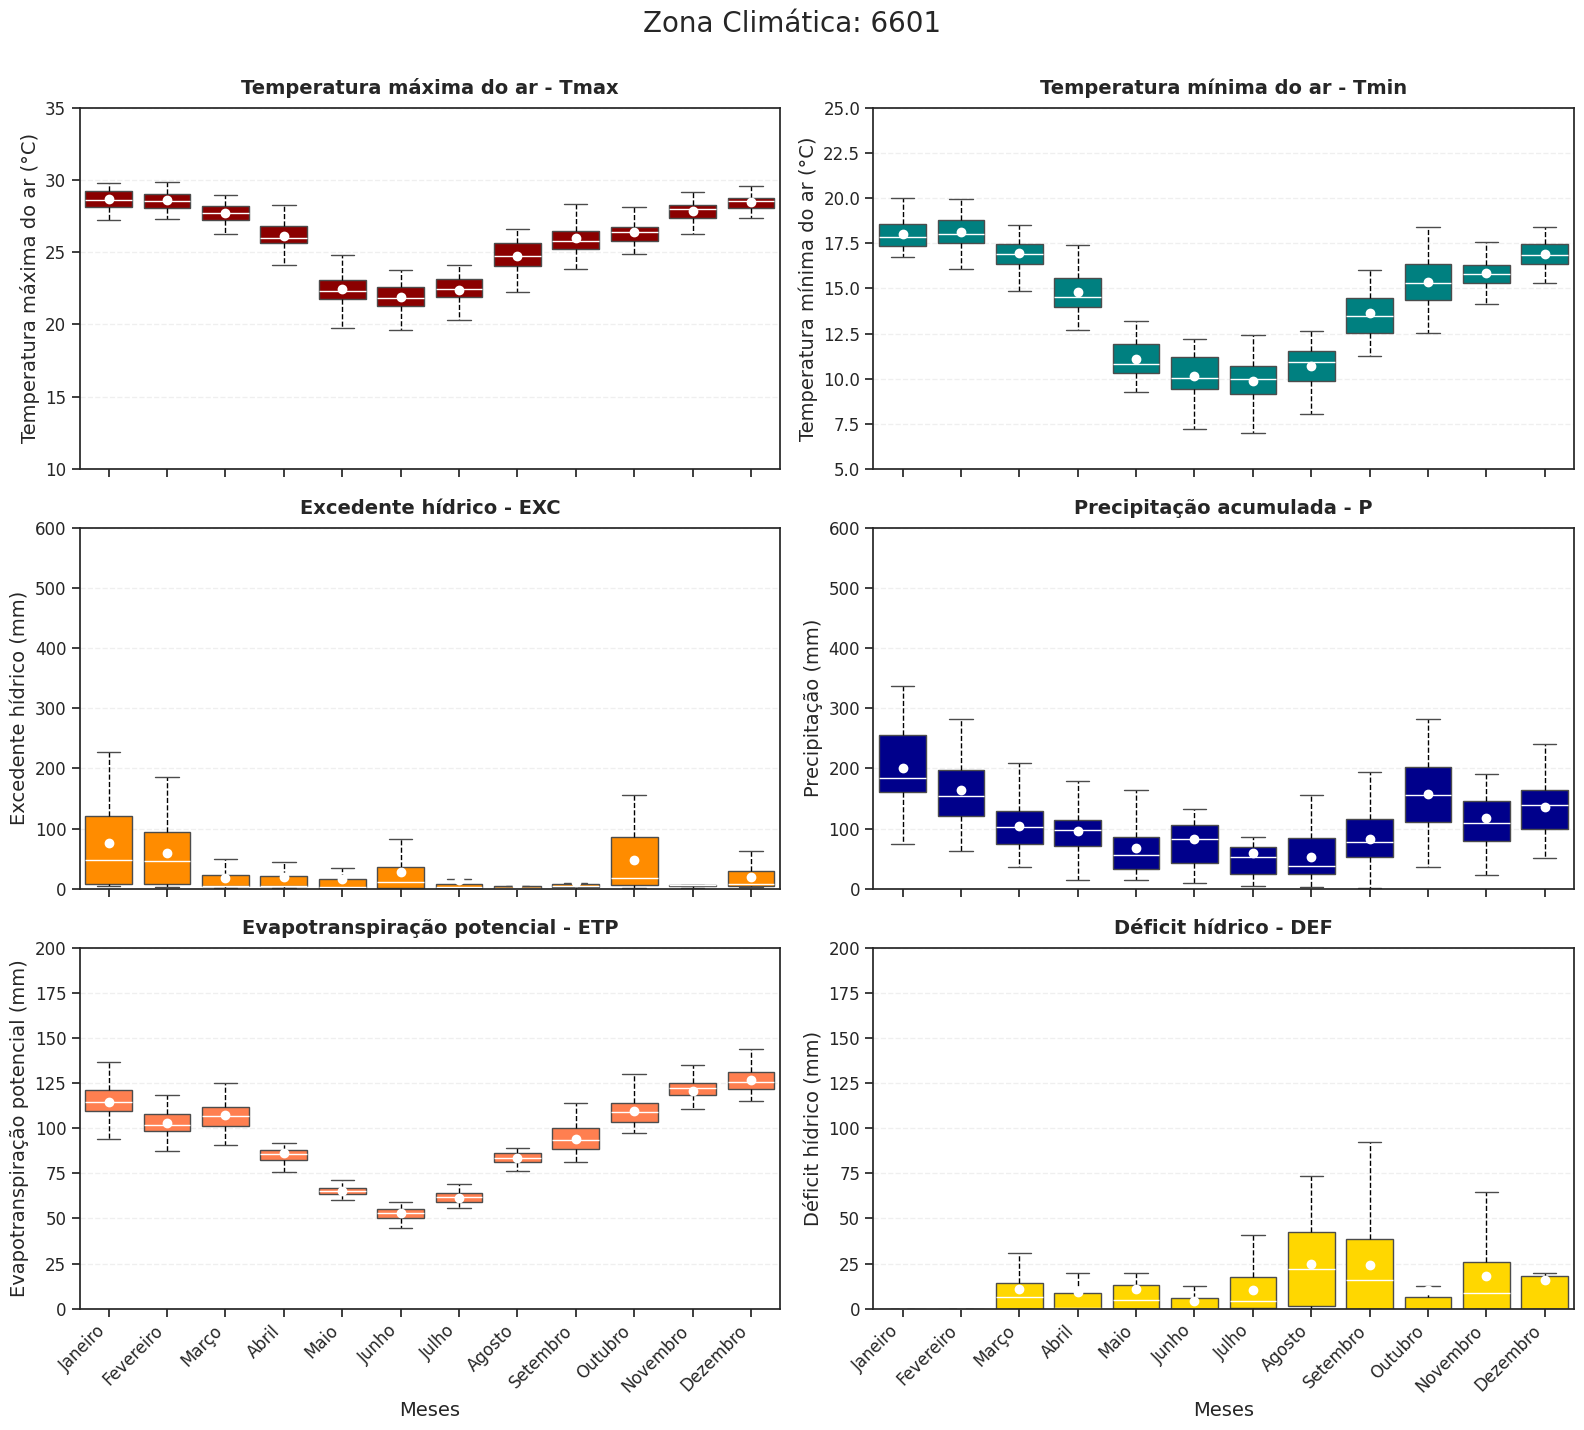

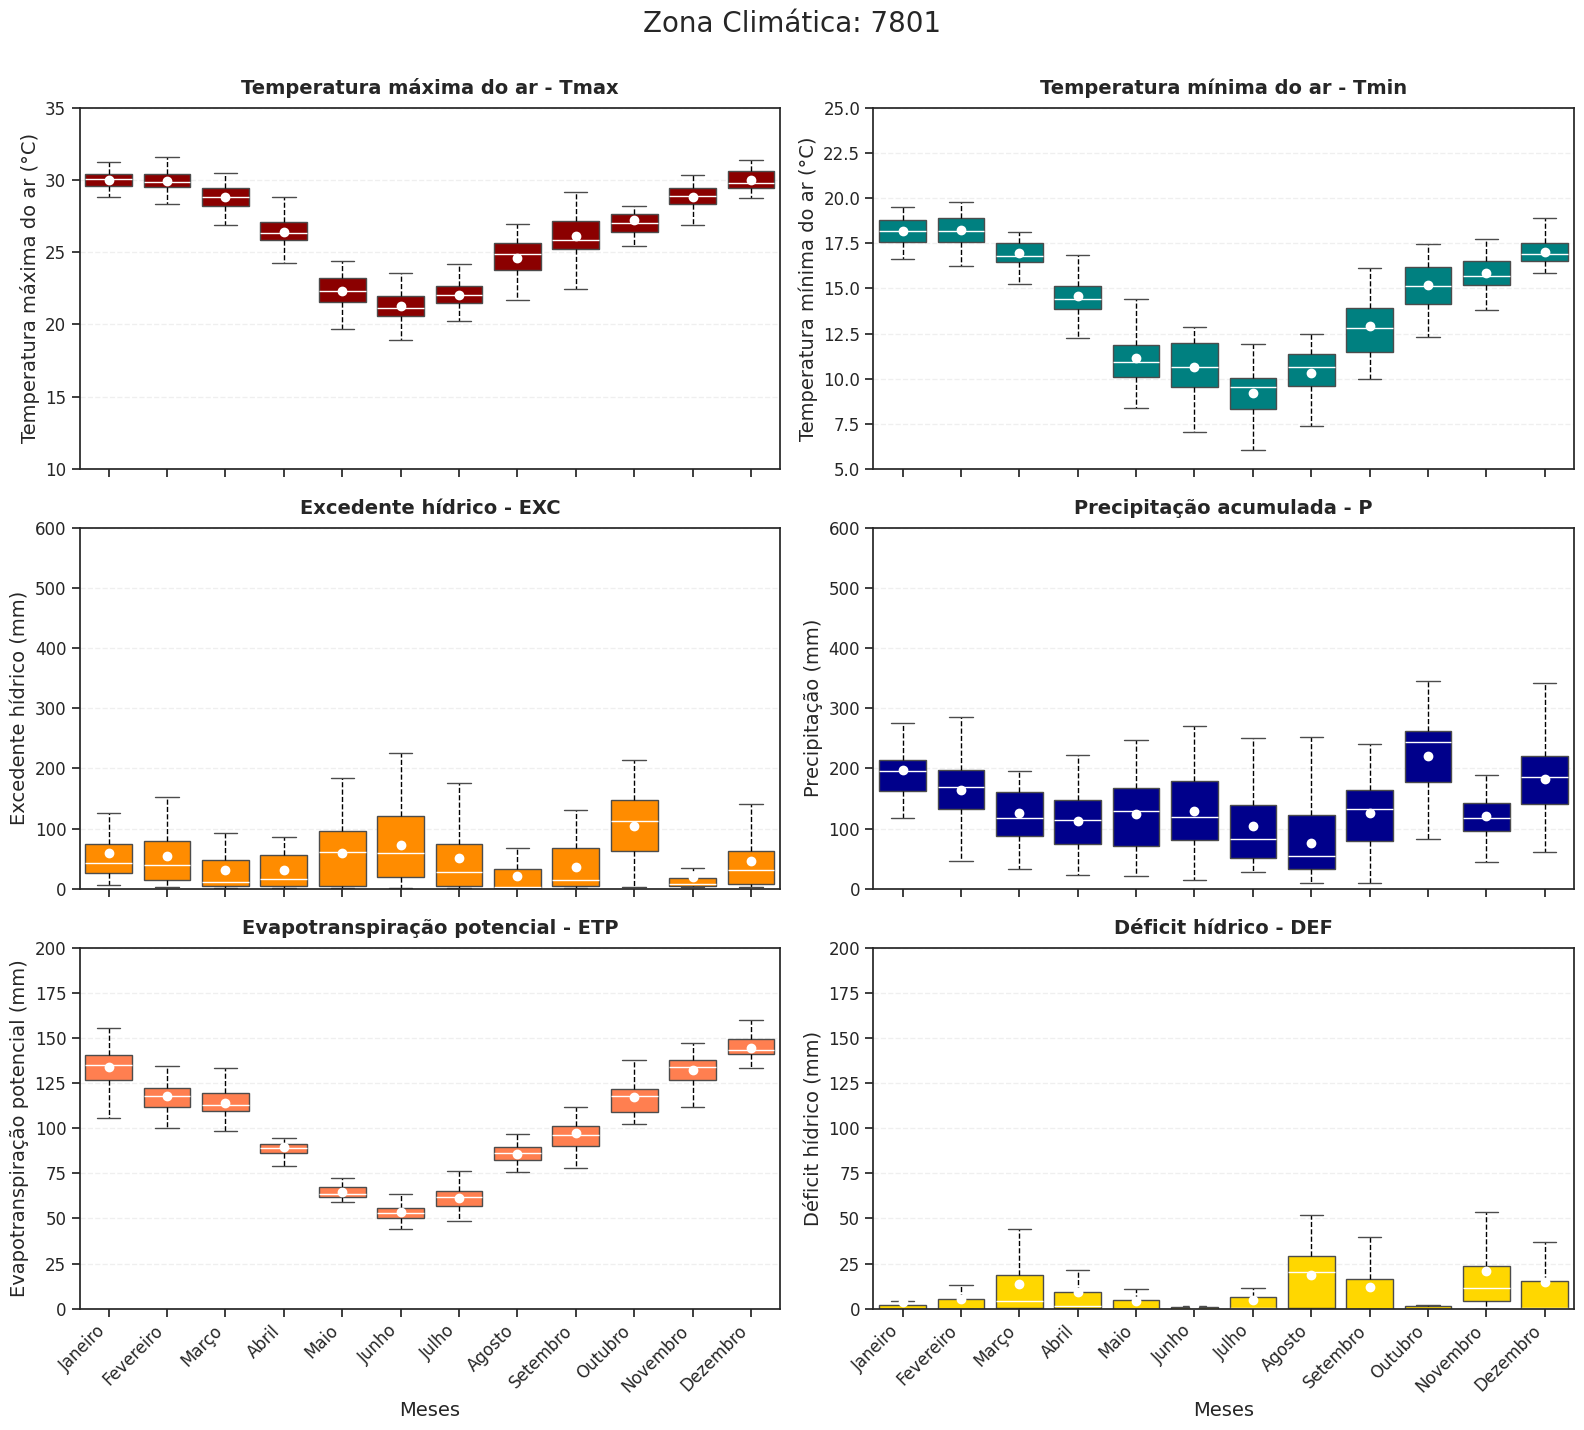

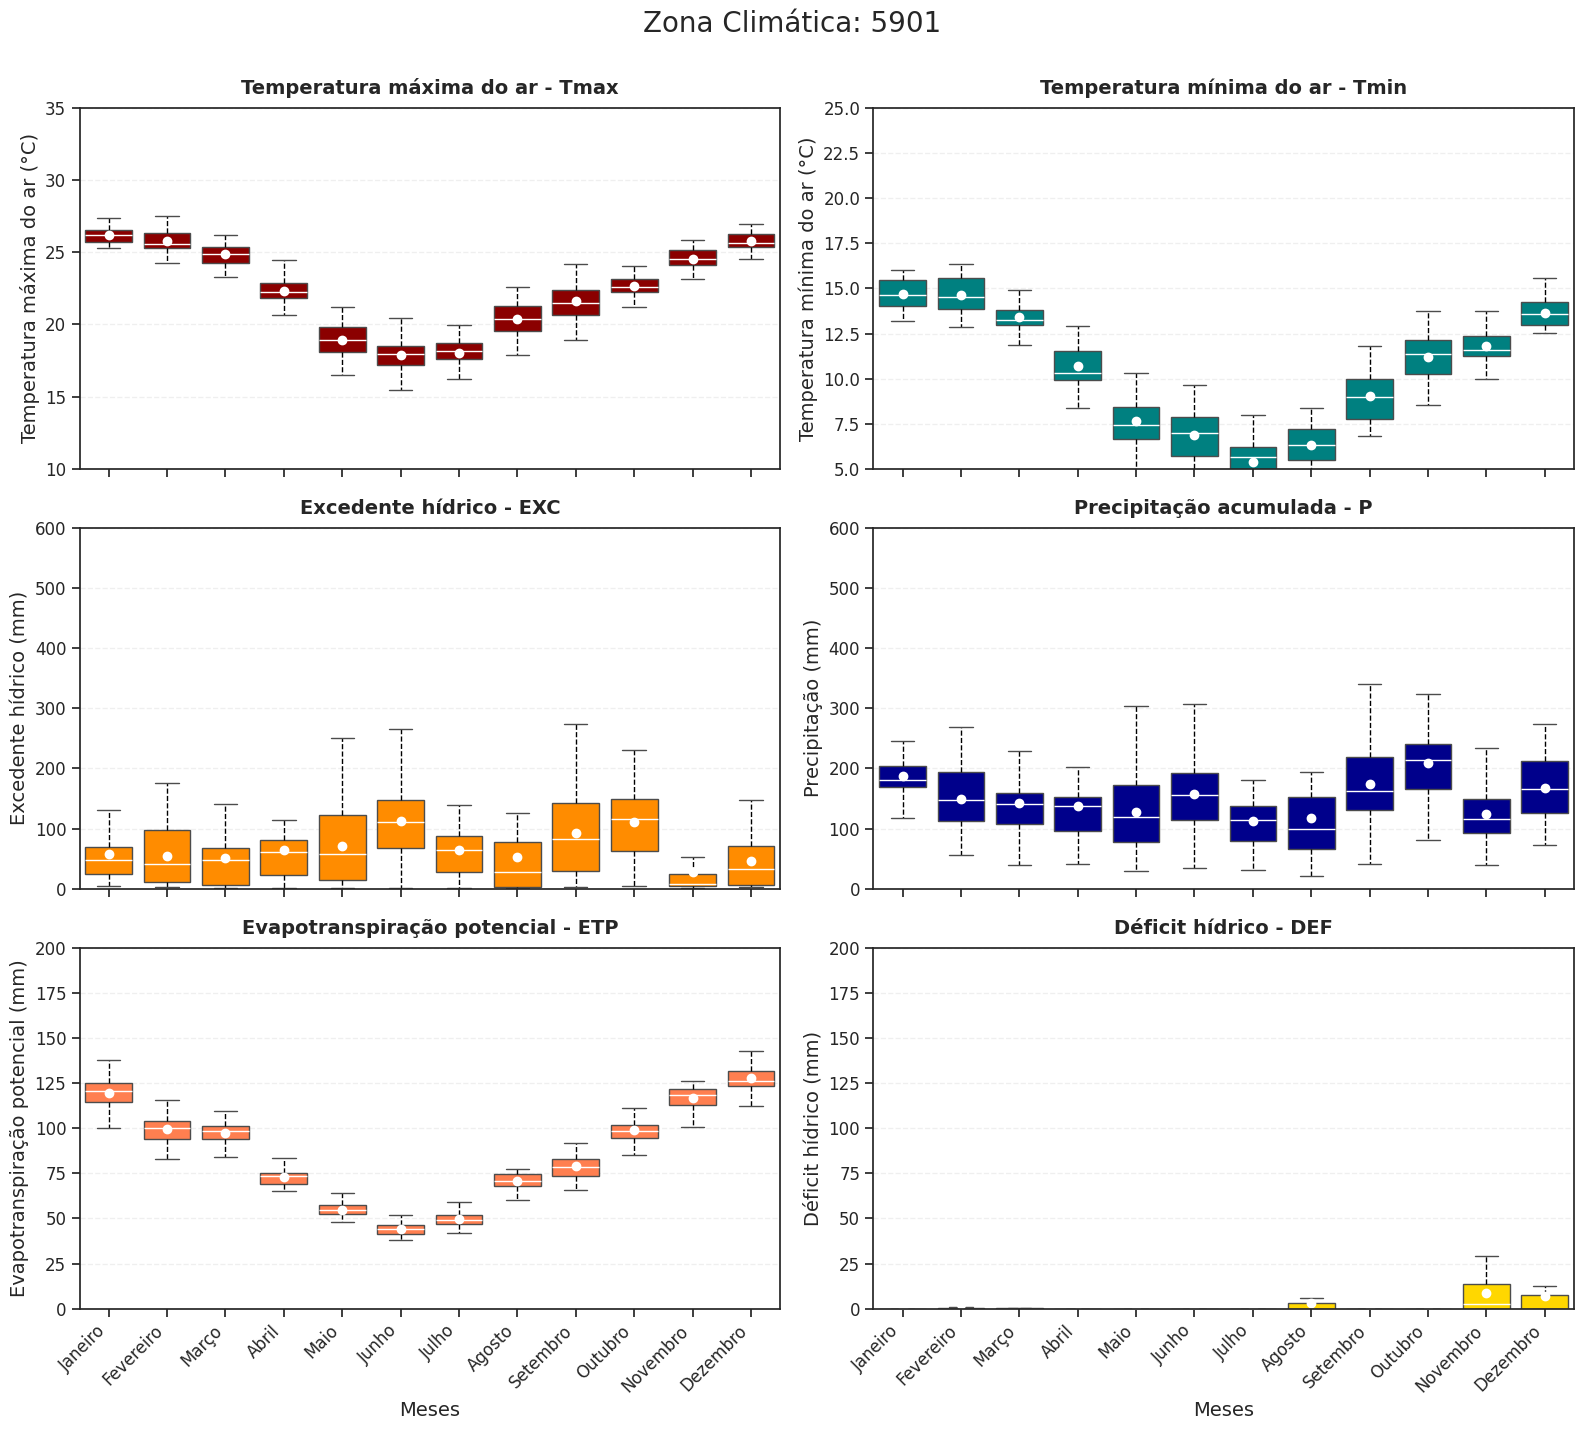

In [30]:
numeros_planilhas = [6801, 7701, 7601, 7501, 7901, 6701, 6901, 6601, 7801, 5901]

for planilha in numeros_planilhas:
    nome_da_planilha = str(planilha)

    url = f"https://raw.githubusercontent.com/fcoliveira-utfpr/climate_parana/refs/heads/main/{nome_da_planilha}.csv"
    df = pd.read_csv(url)
    variavel = df['variavel']
    df = df.drop(columns=['variavel'])
    df = df.replace({',': '.'}, regex=True)
    df = df.apply(lambda x: pd.to_numeric(x, errors='coerce'), axis=1)
    df['variavel'] = variavel
    zona = planilha

    # Lista de variáveis
    variaveis = ['def', 'pet', 'pr', 'ro', 'tmmn', 'tmmx']

    # Filtrar e criar dataframes para cada variável
    dfs = {}
    for variavel in variaveis:
        # Filtrar por variável e selecionar colunas relevantes
        df_filtrado = df[df['variavel'] == variavel]
        df_filtrado = df_filtrado[['ano', 'mes', 'media', 'min', 'max', 'desvio']]
        dfs[variavel] = df_filtrado

    # Configurações do Seaborn
    sns.set()
    sns.set_style('ticks')

    # --- rótulos PT -> número ---
    mes_labels = ["Janeiro", "Fevereiro", "Março", "Abril", "Maio", "Junho",
                  "Julho", "Agosto", "Setembro", "Outubro", "Novembro", "Dezembro"]
    mes_map = {m: i+1 for i, m in enumerate(mes_labels)}

    # ========== DICIONÁRIO DE LIMITES POR VARIÁVEL ==========
    LIMITES_VARIAVEIS = {
        'tmmx': {"vmin": 10, "vmax": 35},    # Temperatura máxima: 10 a 35°C
        'tmmn': {"vmin": 5,  "vmax": 25},    # Temperatura mínima: 5 a 25°C
        'ro':   {"vmin": 0,  "vmax": 600},   # Excedente hídrico: 0 a 600 mm
        'pr':   {"vmin": 0,  "vmax": 600},   # Precipitação: 0 a 600 mm
        'pet':  {"vmin": 0,  "vmax": 200},   # ETP: 0 a 200 mm
        'def':  {"vmin": 0,  "vmax": 200},   # Déficit: 0 a 150 mm
    }

    def _coerce_month_col(df, col='mes'):
        """Converte meses em formato texto para numérico, se necessário"""
        s = df[col]
        if pd.api.types.is_numeric_dtype(s):
            m = s.astype(int)
        else:
            m = s.map(mes_map)
        return df.assign(_mes=m)

    def _order_present(d):
        """Retorna a ordem dos meses presentes no dataframe"""
        present = sorted([int(x) for x in pd.unique(d['_mes'].dropna())])
        return present

    def _xticks_from_order(ax, order):
        """Configura os ticks do eixo X com base na ordem dos meses"""
        labels = [mes_labels[i-1] for i in order]
        ax.set_xticks(range(len(order)))
        ax.set_xticklabels(labels, rotation=45, ha='right')

    def _box_mean(ax, df, facecolor, ylabel, vmin=None, vmax=None):
        """Cria um boxplot com média destacada e limites personalizados"""
        # Converter meses para formato numérico
        d = _coerce_month_col(df).dropna(subset=['_mes', 'media'])

        # Ordem dos meses presentes
        ord_present = _order_present(d)

        # Criar categoria ordenada para os meses
        d = d.assign(_mes_cat=pd.Categorical(d['_mes'], categories=ord_present, ordered=True))

        # Criar boxplot
        sns.boxplot(
            data=d, x='_mes_cat', y='media',
            showcaps=True, showfliers=False,
            boxprops=dict(facecolor=facecolor),
            medianprops=dict(color='white', linewidth=1, linestyle='-'),
            whiskerprops=dict(color='black', linewidth=1, linestyle='dashed'),
            ax=ax
        )

        # Adicionar pontos para a média
        sns.pointplot(
            data=d, x='_mes_cat', y='media',
            estimator='mean', errorbar=None,
            markers="o", markersize=5, linestyles='',
            color='white', ax=ax
        )

        # Aplicar limites personalizados se fornecidos
        if vmin is not None and vmax is not None:
            ax.set_ylim(vmin, vmax)

        # Configurar labels dos eixos
        ax.set_xlabel("Meses", fontsize=14)
        ax.set_ylabel(ylabel, fontsize=14)

        # Configurar ticks do eixo X
        _xticks_from_order(ax, ord_present)

        # Configurar tamanho dos ticks
        ax.tick_params(axis='y', labelsize=12)
        ax.tick_params(axis='x', labelsize=12)

        # Adicionar grid no eixo Y para melhor legibilidade
        ax.grid(True, axis='y', alpha=0.3, linestyle='--')

    # --------- Configuração dos painéis ----------
    panels = [
        {
            "df": dfs['tmmx'],
            "color": "darkred",
            "ylabel": "Temperatura máxima do ar (°C)",
            "title": "Temperatura máxima do ar - Tmax",
            "vmin": LIMITES_VARIAVEIS['tmmx']['vmin'],
            "vmax": LIMITES_VARIAVEIS['tmmx']['vmax']
        },
        {
            "df": dfs['tmmn'],
            "color": "teal",
            "ylabel": "Temperatura mínima do ar (°C)",
            "title": "Temperatura mínima do ar - Tmin",
            "vmin": LIMITES_VARIAVEIS['tmmn']['vmin'],
            "vmax": LIMITES_VARIAVEIS['tmmn']['vmax']
        },
        {
            "df": dfs['ro'],
            "color": "darkorange",
            "ylabel": "Excedente hídrico (mm)",
            "title": "Excedente hídrico - EXC",
            "vmin": LIMITES_VARIAVEIS['ro']['vmin'],
            "vmax": LIMITES_VARIAVEIS['ro']['vmax']
        },
        {
            "df": dfs['pr'],
            "color": "darkblue",
            "ylabel": "Precipitação (mm)",
            "title": "Precipitação acumulada - P",
            "vmin": LIMITES_VARIAVEIS['pr']['vmin'],
            "vmax": LIMITES_VARIAVEIS['pr']['vmax']
        },
        {
            "df": dfs['pet'],
            "color": "coral",
            "ylabel": "Evapotranspiração potencial (mm)",
            "title": "Evapotranspiração potencial - ETP",
            "vmin": LIMITES_VARIAVEIS['pet']['vmin'],
            "vmax": LIMITES_VARIAVEIS['pet']['vmax']
        },
        {
            "df": dfs['def'],
            "color": "gold",
            "ylabel": "Déficit hídrico (mm)",
            "title": "Déficit hídrico - DEF",
            "vmin": LIMITES_VARIAVEIS['def']['vmin'],
            "vmax": LIMITES_VARIAVEIS['def']['vmax']
        },
    ]

    # --------- Criar figura 3x2 ----------
    fig, axes = plt.subplots(3, 2, figsize=(16, 14))
    axes_flat = axes.ravel()

    # Criar cada gráfico
    for ax, cfg in zip(axes_flat, panels):
        _box_mean(ax, cfg["df"], cfg["color"], cfg["ylabel"],
                  vmin=cfg["vmin"], vmax=cfg["vmax"])
        ax.set_title(cfg["title"], fontsize=14, fontweight='bold', pad=10)

    # --- Esconder labels dos meses nas duas primeiras linhas ---
    for i in range(2):  # Linhas 0 e 1
        for j in range(2):  # Colunas 0 e 1
            ax = axes[i, j]
            ax.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)
            ax.set_xlabel("")
            for lbl in ax.get_xticklabels():
                lbl.set_visible(False)

    # --- Mostrar labels dos meses SOMENTE na última linha ---
    for j in range(2):  # Colunas 0 e 1
        ax = axes[2, j]
        # Garantir que os labels estão visíveis
        for lbl in ax.get_xticklabels():
            lbl.set_visible(True)
            lbl.set_rotation(45)
            lbl.set_ha('right')
        ax.tick_params(axis='x', which='both', bottom=True, labelbottom=True)
        ax.set_xlabel("Meses", fontsize=14)

    # Adicionar título geral à figura
    fig.suptitle(f'Zona Climática: {zona}', fontsize=20, y=1.02)

    # Ajustar layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)  # Ajuste para o título geral

    # Mostrar o gráfico
    plt.show()

    # Opcional: Salvar a figura
    fig.savefig(f'analise_climatica_zona_{zona}.png', dpi=300, bbox_inches='tight')

    # Fechar a figura para liberar memória (opcional)
    plt.close(fig)